<a href="https://colab.research.google.com/github/rosesardina/ECE61000-EnergyConversion/blob/main/simple_electromagnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook created by:<br>
Dionysios Aliprantis  |  Professor of
Electrical and Computer Engineering, Purdue University<br>
465 Northwestern Ave., West Lafayette, Indiana 47907-2035<br>
765.494.4434  |  dionysis@purdue.edu<br>
https://engineering.purdue.edu/~dionysis/<br>

Revision: September 10, 2021

Note: This notebook is intended for use by students of ECE 61000 Energy Conversion at Purdue University. The material is subject to change without notice. Unless otherwise noted, figures are obtained from the course textbook: P. Krause, O. Wasynczuk, S. Sudhoff, and S. Pekarek, *Analysis of Electric Machinery and Drive Systems*, Third edition, 2013, Wiley-IEEE Press.

---

# Elementary electromechanical devices: Modeling and simulation

*Objectives:*

* Formulate the dynamic equations of an electromagnet, and simulate its transient response.

*Prerequisites:*

* General interest in power systems engineering and electromechanical devices ;)
* Complete the previous Jupyter notebooks.
* Watch the lecture videos of the Electromechanical Energy Conversion/Energy and Force subsection.

<br>


---




## Electromechanical system

We will analyze the dynamic performance of an elementary electromechanical system (see textbook, Fig. 1.3-3, page 14).

![electromechanical system](https://drive.google.com/uc?id=1zWdBVlW4g2syao7O4x3djigB-lmU3TQ7)

The system parameters are:
* resistance $r = 10~\Omega$
* external inductance $\ell = 0$ H (note: we can change this to a positive value)
* mass $M = 0.055$ kg
* spring resting position $x_0 = 3$ mm
* spring constant $K = 2667$ N/m
* inductance constant $k = 6.293\cdot 10^{-5}$ H$\cdot$m
* damping coefficient $D = 4$ N$\cdot$s/m

This dynamic system has three  *states*, which we will arrange in a vector $\mathbf{y}$, namely:
* the position $y_1 = x >0$
* the velocity $y_2 = px$ ($p = d/dt$, Heaviside notation)
* the current $y_3 = i$

There are two external inputs (forcing terms), which we will arrange in a vector $\mathbf{u}$, namely:
* the voltage $u_1 = v$
* the external force $u_2 = f$

Therefore, given an input $\mathbf{u}(t)$, we can model the evolution of the system dynamics in time using the state derivatives
$$
p\mathbf{y} = \mathbf{f}(\mathbf{y}, \mathbf{u}(t)) \,.
$$
(Note that the coupling field has two  "states" of a different kind, namely $x$ and $i$.)

The voltage   equation of the coil is (see (1.3-7), page 15):
\begin{align}
v &= ri + \ell\, pi + e_f \\
&= ri + \ell\, pi + p(Li) \,.
\end{align}
Expanding the derivative of the product, and using the inductance $$L = L(x) = \frac{k}{x} \,,$$ we have
\begin{align}
v &= ri + \ell\, pi + pL \cdot i + L \cdot pi \\
&= \left(r  + \frac{dL}{dx} px\right) i + (\ell + L) \, pi \\
&= \left( r  - \frac{k}{x^2} px\right ) i + \left(\ell + \frac{k}{x} \right) \, pi \,.
\end{align}

The mechanical subsystem is governed by Newton's law of motion (see (1.3-8), page 15):
$$
f + f_e - K(x-x_0) - D \, px = M \, p^2 x \,,
$$
where the electromagnetic force is given by (1.3-81),
$$
f_e = f_e(x) = -\frac{k i^2}{2x^2} \,.
$$

Writing this in "canonical form", that is, the expression $p\mathbf{y} = \mathbf{f}(\mathbf{y},\mathbf{u})$ involving only first derivatives, we obtain
\begin{align}
py_1 & = y_2 \\
py_2 & = \frac{1}{M} \cdot \left[ u_2 - \frac{k}{2} \left( \frac{y_3}{y_1} \right)^2 - K(y_1 - x_0) - D y_2\right] \\
py_3 &= \frac{y_1}{\ell y_1 + k} \cdot \left[ u_1 - \left(r - \frac{k}{y_1^2}y_2 \right) y_3 \right] \,.
\end{align}
This was achieved by introducing an auxiliary variable $y_2 = py_1 = px$ (the velocity), whose derivative $p y_2 = p^2 y_1 = p^2 x$ is the acceleration.
We wrote the equations in this form, to make it clear that this is a nonlinear system of ordinary differential equations, which cannot be solved by hand. We must resort to the computer for a numerical solution.

Our simulation will start from an equilibrium, where all time derivatives are zero, and the states satisfy:
\begin{align}
0 & = y_2 \\
0 & = \frac{1}{M} \cdot \left[ u_2 - \frac{k}{2} \left( \frac{y_3}{y_1} \right)^2 - K(y_1 - x_0) \right] \\
0 &= \frac{y_1}{\ell y_1 + k} \cdot ( u_1 - r y_3 ) \,,
\end{align}
leading to
\begin{align}
K y_1^3 - (K x_0 + u_2) y_1^2 + \tfrac{1}{2}k y_3^2   &= 0 ~~~~~\text{(force balance)}\\
y_2 &= 0 ~~~~~\text{(the mass is not moving)} \\
y_3 &= \frac{u_1}{r} ~~\text{(Ohm's law)}
\end{align}
The equilibrium current ($y_3$) and the velocity ($y_2$) are determined very easily. However, a nonlinear (cubic) equation needs to be solved for the initial position ($y_1$). (We will use the computer to get the roots, without having to look up  complicated analytical expressions.)
Figure 1.3-9, page 30, provides a nice illustration of the equilibrium conditions.
We need to select the *stable* equilibrium point from the three roots of $y_1$.


### Import Python libraries

In [ ]:
# Import libraries we need to calculate
import numpy as np
import scipy.integrate as spint

# Import plotting library and set defaults
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
#sns.set_context("talk")
#plt.style.use("dark_background")

### Define device parameters

In [ ]:
# define device parameters (see pages 30-31)
r          =  10 # resistance (ohm)
ell        =  0 # external inductance (henries, H)
M          =  0.055 # mass (kg)
x_0        =  3e-3 # spring resting position (m)
K          =  2667 # spring constant (N/m)
k_L        =  6.293e-5 # inductance constant (H*m)
D          =  4 # damping coefficient (N*s/m)

### Calculate the transient response

Our problem is of the form:
$$
p\mathbf{y} = \mathbf{f}(\mathbf{y}, t) ~~\text{with}~~\mathbf{y}(0) = \mathbf{y}_0 \,.
$$

We will use the solve_ivp function from scipy.integrate to obtain a numerical solution to our initial value problem.
For more information about this, please refer to the online documentation: https://docs.scipy.org/doc/scipy/reference/integrate.html

We can simulate two case studies, as described in the textbook. These are selected based on the CASE_STUDY variable in line 21 of the code below. The first case study involves a step of the voltage with zero external force, and the second case study involves a step of the force with constant voltage (5V).


The solver successfully reached the end of the integration interval.


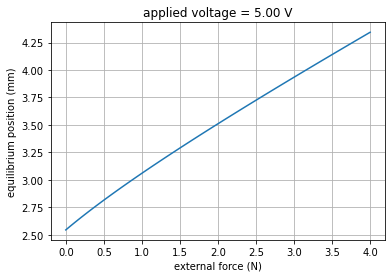

In [ ]:
# solve equilibrium given external forcing terms
def calculate_eq(v_0,f_0):
  y_2 = 0 # velocity
  y_3 = v_0/r # current
  rts = np.roots([K,-(K*x_0 + f_0),0,0.5*k_L*y_3**2])
  y_1 = np.amax(rts) # position (choose the stable equilibrium)
  return np.array([y_1,y_2,y_3])

# calculate and plot equilibrium position (sanity check)
v_0 = 5
f_0 = np.linspace(0,4,100)
pos_0 = np.zeros(f_0.size)
for k in range(f_0.size):
  pos_0[k] = calculate_eq(v_0,f_0[k])[0]
plt.figure()
plt.plot(f_0,pos_0*1e3)
plt.xlabel('external force (N)')
plt.ylabel('equilibrium position (mm)')
plt.title('applied voltage = {:.2f} V'.format(v_0))
plt.grid()

CASE_STUDY = 2 # 1:voltage step or 2:force step

# voltage source
def v(t):
  if CASE_STUDY == 1:
    t_1 = 0.02
    t_2 = 0.1
    if t < t_1:
      return 0
    elif t < t_2:
      return 5
    else:
      return 0
  elif CASE_STUDY == 2:
    return 5

# external force
def f(t):
  if CASE_STUDY == 1:
    return 0
  elif CASE_STUDY == 2:
    t_1 = 0.02
    t_2 = 0.1
    if t < t_1:
      return 0
    elif t < t_2:
      return 4
    else:
      return 0

# derivative function
def fun(t, y):
  py = np.zeros(3)
  u_1 = v(t)
  u_2 = f(t)

  py[0] = y[1]
  py[1] = 1/M*(u_2 - k_L/2*(y[2]/y[0])**2 - K*(y[0] - x_0) - D*y[1])
  py[2] = y[0]/(ell*y[0] + k_L)*(u_1 - (r - k_L/y[0]**2*y[1])*y[2])
  return py

# solve ODE
y_0        = calculate_eq(v(0),f(0)) # initial condition
t_span     = (0,0.18) # time span
N_pts      = 1000
t_eval     = np.linspace(t_span[0],t_span[-1],N_pts)
sol        = spint.solve_ivp(fun, t_span, y_0, method='RK45', t_eval=t_eval,\
                             vectorized=False)
print(sol.message)

t = sol.t
x = sol.y[0,:]
px = sol.y[1,:]
i = sol.y[2,:]

# post-processing for quantities of interest
py = np.zeros((3,t.size)) # state derivatives
for k in range(t.size):
  py[:,k] = fun(t[k],sol.y[:,k])
pi = py[2,:] # di/dt, not 3.1415...
x_sq = np.square(x)
dL_dx = -np.divide(k_L,x_sq)
pL = np.multiply(dL_dx,px)
e_f = np.multiply(pL,i) + k_L*np.divide(pi,x)
lam = k_L*np.divide(i,x)
i_sq = np.square(i)
f_e = -k_L/2*np.divide(i_sq,x_sq)
W_e = spint.cumtrapz(np.multiply(i,e_f),t,initial=0) # delta(W_e)
W_m = spint.cumtrapz(np.multiply(-f_e,px),t,initial=0) # delta(W_m)
W_f = 1/2*np.multiply(lam,i) # magnetically linear system

Now, let's plot the solution, trying to imitate exactly the plots shown in the text on pages 31–33.

A minor difference is that we are calculating the *change* in the electrical and mechanical work $\delta W$, by integrating electrical and mechanical power starting from an initial value of zero (i.e., not accounting for the work performed prior to the start of the simulation that was needed to energize the circuit for the second case study). In the textbook, an initial offset is added to these integrals.

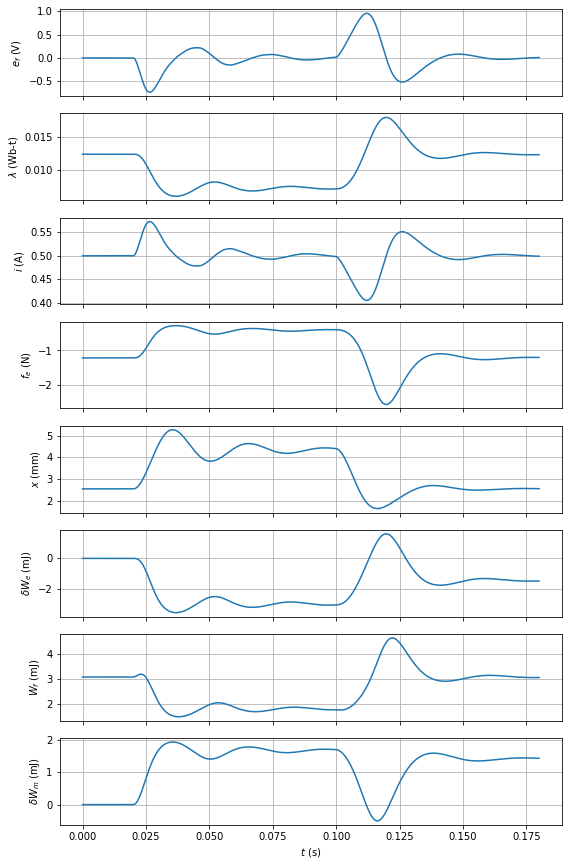

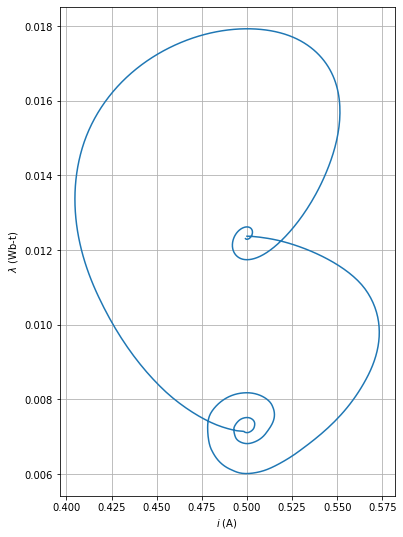

In [ ]:
# Plot currents and power
plt.figure(figsize=(9,15))

ax = plt.subplot(8,1,1)
plt.plot(t,e_f)
plt.ylabel(r'$e_f$ (V)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,2)
plt.plot(t,lam)
plt.ylabel(r'$\lambda$ (Wb-t)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,3)
plt.plot(t,i)
plt.ylabel(r'$i$ (A)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,4)
plt.plot(t,f_e)
plt.ylabel(r'$f_e$ (N)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,5)
plt.plot(t,x*1e3)
plt.ylabel(r'$x$ (mm)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,6)
plt.plot(t,W_e*1e3)
plt.ylabel(r'$\delta W_e$ (mJ)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,7)
plt.plot(t,W_f*1e3)
plt.ylabel(r'$W_f$ (mJ)')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(8,1,8)
plt.plot(t,W_m*1e3)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\delta W_m$ (mJ)');
plt.grid()


plt.figure(figsize=(6,9))
plt.plot(i,lam)
plt.xlabel(r'$i$ (A)')
plt.ylabel(r'$\lambda$ (Wb-t)')
plt.grid();

###Exercises:

1. We have plotted above the transient on the $i$-$\lambda$ plane.
We know that the energy entering the coupling field from the electrical subsystem is given by
$$
W_e = \int i \, d\lambda \,.
$$
Identify the area represented by this integral graphically on the plot throughout the evolution of the transient.
Draw an area that represents the total energy transferred over one cycle.

1. Suppose that the input voltage is ac, e.g.,
$$
v(t) = \sqrt{2} \cdot 10 \cdot \cos(377t) \,.
$$
Simulate the response of the device starting from the demagnetized state, with or without the presence of an external force $f$.
Choose an appropriate large time span to observe the energy loss over time.
Provide an interpretation of the results.

1. One limitation of the above model is that it breaks down when the position $x$ gets close to zero, because the inductance and the force become infinitely large. This could happen, for instance, if the applied voltage magnitude is large enough.
Suppose that we modify the meaning of $x$, so that it is now measured 1mm from within the device.
Also suppose that our inductance model is still valid even with this conceptual modification.
Hence, we must set a hard limit of $ x \geq x_{\text{min}} = 1$ mm in the equations.
The problem is to modify the derivative function to account for this kinematic constraint, and to implement this limit in the dynamic simulation.
[*Hint:* The correct way to achieve this is to define an *event* in the integration algorithm for accurately detecting the time when $x$ reaches $x_{\text{min}}$. Please see the documentation of solve_ivp for more details.]

1. Reverse engineer the magnetic circuit: Apply your understanding of magnetic equivalent circuits to determine the actual physical dimensions and design parameters (e.g., number of turns, coil gauge) of this device. Try to match the given parameters as closely as possible.  



---


## Conclusion

We simulated the dynamics of an elementary electromechanical actuator, involving  electrical and  mechanical subsystems coupled through a magnetic field.
Even for this simple device, the equations turn out to be nonlinear, and require the use of the computer for numerical analysis.




